# Class 3c: Funding Rate Arbitrage & Perpetual Futures Analysis

**Learning Objectives:**
- Monitor perpetual futures funding rates across multiple exchanges
- Identify cash-and-carry arbitrage opportunities
- Calculate annualized funding rate costs
- Understand when arbitrage is profitable vs risky

**Required from planning.pdf:**
> "Monitor perpetual funding rates across exchanges (Binance, Bybit) and identify arbitrage opportunities."

**Recap from Class 2:**
- Perpetual futures = futures contracts with no expiry date
- Funding rate = periodic payment between longs and shorts
- Positive funding = longs pay shorts (bullish sentiment)
- Negative funding = shorts pay longs (bearish sentiment)

---

## 1. Setup and Imports

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time

# Data fetching
import requests

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print("✅ Libraries imported successfully")
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Libraries imported successfully
Analysis Date: 2025-11-02 13:47:16


## 2. Understanding Funding Rates

**Key Concepts:**

### What is Funding Rate?
- **Payment frequency:** Every 8 hours (3x per day)
- **Direction:** 
  - Positive rate → Longs pay shorts (market is bullish)
  - Negative rate → Shorts pay longs (market is bearish)
- **Typical range:** -0.05% to +0.10% per 8 hours

### Cash-and-Carry Arbitrage:
When funding rate is **high and positive**, you can:
1. **Buy spot** (e.g., 1 BTC on Binance Spot)
2. **Short perp** (e.g., 1 BTC on Binance Futures)
3. **Collect funding** every 8 hours (longs pay you)
4. **Delta neutral** = no price risk (spot + short = 0)

### When is it profitable?
Funding rate must exceed your costs:
- Trading fees (spot buy + futures short)
- Slippage
- Margin requirements
- Withdrawal fees (if moving funds)

**Breakeven example:**
- Spot buy: 0.1% fee
- Futures short: 0.02% fee
- **Total cost:** 0.12%
- **Need:** Funding rate > 0.04% per day (0.12% / 3 days to break even)
- **Annualized:** 14.6% APR minimum

---

## 3. Fetch Current Funding Rates (Multiple Exchanges)

In [ ]:
def fetch_binance_funding_rate(symbol='BTCUSDT', max_retries=3):
    """
    Fetch current funding rate from Binance Futures with exponential backoff.
    
    Args:
        symbol (str): Trading pair (e.g., 'BTCUSDT')
        max_retries (int): Maximum number of retry attempts
    
    Returns:
        dict: Funding rate data or None if failed
    """
    url = "https://fapi.binance.com/fapi/v1/premiumIndex"
    params = {'symbol': symbol}
    
    for attempt in range(max_retries):
        try:
            response = requests.get(url, params=params, timeout=10)
            if response.status_code == 200:
                data = response.json()
                return {
                    'exchange': 'Binance',
                    'symbol': symbol,
                    'funding_rate': float(data['lastFundingRate']) * 100,  # Convert to %
                    'next_funding_time': datetime.fromtimestamp(data['nextFundingTime'] / 1000),
                    'mark_price': float(data['markPrice'])
                }
            elif response.status_code == 429:  # Rate limited
                wait_time = (2 ** attempt) * 2
                print(f"⚠️  Binance rate limited. Waiting {wait_time}s... (attempt {attempt + 1}/{max_retries})")
                time.sleep(wait_time)
            else:
                print(f"⚠️  Binance returned {response.status_code} (attempt {attempt + 1}/{max_retries})")
                time.sleep(2 ** attempt)
        except Exception as e:
            print(f"⚠️  Binance error: {e} (attempt {attempt + 1}/{max_retries})")
            if attempt < max_retries - 1:
                time.sleep(2 ** attempt)
    
    return None


def fetch_bybit_funding_rate(symbol='BTCUSDT', max_retries=3):
    """
    Fetch current funding rate from Bybit with exponential backoff.
    """
    url = "https://api.bybit.com/v5/market/tickers"
    params = {
        'category': 'linear',
        'symbol': symbol
    }
    
    for attempt in range(max_retries):
        try:
            response = requests.get(url, params=params, timeout=10)
            if response.status_code == 200:
                data = response.json()
                if data['retCode'] == 0 and len(data['result']['list']) > 0:
                    ticker = data['result']['list'][0]
                    return {
                        'exchange': 'Bybit',
                        'symbol': symbol,
                        'funding_rate': float(ticker.get('fundingRate', 0)) * 100,
                        'next_funding_time': datetime.fromtimestamp(int(ticker.get('nextFundingTime', 0)) / 1000) if ticker.get('nextFundingTime') else None,
                        'mark_price': float(ticker.get('markPrice', 0))
                    }
            elif response.status_code == 429:
                wait_time = (2 ** attempt) * 2
                print(f"⚠️  Bybit rate limited. Waiting {wait_time}s... (attempt {attempt + 1}/{max_retries})")
                time.sleep(wait_time)
            else:
                print(f"⚠️  Bybit returned {response.status_code} (attempt {attempt + 1}/{max_retries})")
                time.sleep(2 ** attempt)
        except Exception as e:
            print(f"⚠️  Bybit error: {e} (attempt {attempt + 1}/{max_retries})")
            if attempt < max_retries - 1:
                time.sleep(2 ** attempt)
    
    return None


def generate_simulated_funding_rates():
    """
    Generate realistic simulated funding rates for educational purposes.
    """
    print("⚠️  Using simulated funding rate data for educational purposes.")
    
    # Typical funding rate parameters
    base_rate = 0.01  # 0.01% base (neutral market)
    
    # Simulate market sentiment
    sentiment = np.random.choice(['bullish', 'neutral', 'bearish'], p=[0.5, 0.3, 0.2])
    
    if sentiment == 'bullish':
        btc_rate = np.random.uniform(0.02, 0.10)  # High positive
        eth_rate = np.random.uniform(0.015, 0.08)
    elif sentiment == 'bearish':
        btc_rate = np.random.uniform(-0.05, 0.01)  # Negative or low
        eth_rate = np.random.uniform(-0.04, 0.02)
    else:
        btc_rate = np.random.uniform(-0.01, 0.03)  # Neutral
        eth_rate = np.random.uniform(-0.01, 0.025)
    
    # Add exchange variation (different exchanges have slightly different rates)
    binance_btc = btc_rate + np.random.normal(0, 0.005)
    bybit_btc = btc_rate + np.random.normal(0, 0.005)
    binance_eth = eth_rate + np.random.normal(0, 0.004)
    bybit_eth = eth_rate + np.random.normal(0, 0.004)
    
    next_funding = datetime.now() + timedelta(hours=np.random.randint(1, 8))
    
    return [
        {
            'exchange': 'Binance',
            'symbol': 'BTCUSDT',
            'funding_rate': binance_btc,
            'next_funding_time': next_funding,
            'mark_price': 67500 + np.random.normal(0, 500)
        },
        {
            'exchange': 'Bybit',
            'symbol': 'BTCUSDT',
            'funding_rate': bybit_btc,
            'next_funding_time': next_funding,
            'mark_price': 67500 + np.random.normal(0, 500)
        },
        {
            'exchange': 'Binance',
            'symbol': 'ETHUSDT',
            'funding_rate': binance_eth,
            'next_funding_time': next_funding,
            'mark_price': 3200 + np.random.normal(0, 50)
        },
        {
            'exchange': 'Bybit',
            'symbol': 'ETHUSDT',
            'funding_rate': bybit_eth,
            'next_funding_time': next_funding,
            'mark_price': 3200 + np.random.normal(0, 50)
        }
    ]


# Fetch current funding rates
print("🔄 Fetching current funding rates...\n")

funding_rates = []

# Try to fetch real data with retry
for symbol in ['BTCUSDT', 'ETHUSDT']:
    print(f"Fetching {symbol}...")
    binance_data = fetch_binance_funding_rate(symbol, max_retries=3)
    if binance_data:
        funding_rates.append(binance_data)
        print(f"  ✅ Binance {symbol}: {binance_data['funding_rate']:.4f}%")
    time.sleep(0.5)
    
    bybit_data = fetch_bybit_funding_rate(symbol, max_retries=3)
    if bybit_data:
        funding_rates.append(bybit_data)
        print(f"  ✅ Bybit {symbol}: {bybit_data['funding_rate']:.4f}%")
    time.sleep(0.5)

# If no real data, use simulated
if len(funding_rates) == 0:
    print("\n⚠️  All API calls failed. Using simulated data.")
    funding_rates = generate_simulated_funding_rates()
elif len(funding_rates) < 4:
    print(f"\n⚠️  Only fetched {len(funding_rates)}/4 rates. Filling missing with simulated data.")
    # Fill missing exchanges/symbols
    existing = {(r['exchange'], r['symbol']) for r in funding_rates}
    simulated = generate_simulated_funding_rates()
    for sim in simulated:
        if (sim['exchange'], sim['symbol']) not in existing:
            funding_rates.append(sim)

# Create DataFrame
df_current = pd.DataFrame(funding_rates)

print("\n" + "="*70)
print("📊 CURRENT FUNDING RATES")
print("="*70)
print(df_current.to_string(index=False))
print("\n" + "="*70)

# Calculate annualized rates
df_current['daily_rate'] = df_current['funding_rate'] * 3  # 3 funding periods per day
df_current['annualized_rate'] = df_current['daily_rate'] * 365

print("\n💰 ANNUALIZED FUNDING RATES:")
for _, row in df_current.iterrows():
    print(f"   {row['exchange']:8} {row['symbol']:10} | "
          f"8H: {row['funding_rate']:+.4f}% | "
          f"Daily: {row['daily_rate']:+.3f}% | "
          f"Annual: {row['annualized_rate']:+.1f}%")

## 4. Fetch Historical Funding Rates (30 Days)

In [ ]:
def fetch_binance_funding_history(symbol='BTCUSDT', days=30, max_retries=3):
    """
    Fetch historical funding rates from Binance with exponential backoff.
    """
    url = "https://fapi.binance.com/fapi/v1/fundingRate"
    
    start_time = int((datetime.now() - timedelta(days=days)).timestamp() * 1000)
    end_time = int(datetime.now().timestamp() * 1000)
    
    params = {
        'symbol': symbol,
        'startTime': start_time,
        'endTime': end_time,
        'limit': 1000
    }
    
    for attempt in range(max_retries):
        try:
            response = requests.get(url, params=params, timeout=15)
            if response.status_code == 200:
                data = response.json()
                
                df = pd.DataFrame(data)
                df['fundingTime'] = pd.to_datetime(df['fundingTime'], unit='ms')
                df['fundingRate'] = df['fundingRate'].astype(float) * 100  # Convert to %
                df = df.rename(columns={'fundingTime': 'timestamp', 'fundingRate': 'funding_rate'})
                df['exchange'] = 'Binance'
                df['symbol'] = symbol
                
                return df[['timestamp', 'exchange', 'symbol', 'funding_rate']]
            elif response.status_code == 429:
                wait_time = (2 ** attempt) * 2
                print(f"  ⚠️  Rate limited. Waiting {wait_time}s... (attempt {attempt + 1}/{max_retries})")
                time.sleep(wait_time)
            else:
                print(f"  ⚠️  API returned {response.status_code} (attempt {attempt + 1}/{max_retries})")
                time.sleep(2 ** attempt)
        except Exception as e:
            print(f"  ⚠️  Error: {e} (attempt {attempt + 1}/{max_retries})")
            if attempt < max_retries - 1:
                time.sleep(2 ** attempt)
    
    return None


def generate_simulated_funding_history(symbol='BTCUSDT', days=30):
    """
    Generate realistic simulated funding rate history.
    """
    # Generate timestamps (3 per day for 30 days = 90 data points)
    periods = days * 3
    end_date = datetime.now()
    timestamps = [end_date - timedelta(hours=8*i) for i in range(periods)]
    timestamps.reverse()
    
    # Generate funding rates with realistic patterns
    base_rate = 0.01
    
    # Add trends and cycles
    trend = np.linspace(0.02, 0.05, periods)  # Upward trend (increasing bullishness)
    cycle = np.sin(np.linspace(0, 4*np.pi, periods)) * 0.02  # Cyclical pattern
    noise = np.random.normal(0, 0.01, periods)  # Random noise
    
    funding_rates = base_rate + trend + cycle + noise
    
    # Add some extreme events (funding spikes)
    spike_indices = np.random.choice(periods, size=3, replace=False)
    funding_rates[spike_indices] += np.random.uniform(0.05, 0.15, 3)
    
    df = pd.DataFrame({
        'timestamp': timestamps,
        'exchange': 'Binance',
        'symbol': symbol,
        'funding_rate': funding_rates
    })
    
    return df


# Fetch historical data
print("🔄 Fetching 30-day funding rate history...\n")

df_history_btc = fetch_binance_funding_history('BTCUSDT', days=30, max_retries=3)
if df_history_btc is None or len(df_history_btc) == 0:
    print("⚠️  Using simulated BTC funding history")
    df_history_btc = generate_simulated_funding_history('BTCUSDT', days=30)
else:
    print(f"✅ Fetched {len(df_history_btc)} BTC funding rate records from Binance")

time.sleep(1)

df_history_eth = fetch_binance_funding_history('ETHUSDT', days=30, max_retries=3)
if df_history_eth is None or len(df_history_eth) == 0:
    print("⚠️  Using simulated ETH funding history")
    df_history_eth = generate_simulated_funding_history('ETHUSDT', days=30)
else:
    print(f"✅ Fetched {len(df_history_eth)} ETH funding rate records from Binance")

# Combine
df_history = pd.concat([df_history_btc, df_history_eth], ignore_index=True)

print(f"\n✅ Total historical records: {len(df_history)}")
print(f"   Date range: {df_history['timestamp'].min().strftime('%Y-%m-%d')} to {df_history['timestamp'].max().strftime('%Y-%m-%d')}")

# Calculate statistics
print("\n📊 FUNDING RATE STATISTICS (30 Days):")
for symbol in ['BTCUSDT', 'ETHUSDT']:
    df_sym = df_history[df_history['symbol'] == symbol]
    if len(df_sym) > 0:
        mean_rate = df_sym['funding_rate'].mean()
        median_rate = df_sym['funding_rate'].median()
        max_rate = df_sym['funding_rate'].max()
        min_rate = df_sym['funding_rate'].min()
        std_rate = df_sym['funding_rate'].std()
        
        print(f"\n{symbol}:")
        print(f"   Mean: {mean_rate:+.4f}%")
        print(f"   Median: {median_rate:+.4f}%")
        print(f"   Max: {max_rate:+.4f}%")
        print(f"   Min: {min_rate:+.4f}%")
        print(f"   Std Dev: {std_rate:.4f}%")
        print(f"   Annualized (mean): {mean_rate * 3 * 365:+.1f}%")

## 5. Identify Arbitrage Opportunities

**Breakeven Analysis:**
- Spot trading fee: 0.1%
- Futures trading fee: 0.02%
- **Total entry cost:** 0.12%
- **Minimum profitable rate:** 0.04% per day (14.6% APR)

Any funding rate above this threshold is potentially profitable.

In [4]:
# Define cost structure
SPOT_FEE = 0.10  # 0.10%
FUTURES_FEE = 0.02  # 0.02%
TOTAL_COST = SPOT_FEE + FUTURES_FEE  # 0.12%

# Calculate breakeven rates
BREAKEVEN_PER_FUNDING = TOTAL_COST / 3  # Spread over 3 funding periods (1 day)
BREAKEVEN_DAILY = TOTAL_COST
BREAKEVEN_ANNUAL = BREAKEVEN_DAILY * 365

print("💰 CASH-AND-CARRY ARBITRAGE COST ANALYSIS")
print("="*70)
print(f"\n📊 Cost Structure:")
print(f"   Spot trading fee: {SPOT_FEE:.2f}%")
print(f"   Futures trading fee: {FUTURES_FEE:.2f}%")
print(f"   Total entry cost: {TOTAL_COST:.2f}%")

print(f"\n🎯 Breakeven Funding Rates:")
print(f"   Per funding period (8H): {BREAKEVEN_PER_FUNDING:.4f}%")
print(f"   Daily: {BREAKEVEN_DAILY:.2f}%")
print(f"   Annualized: {BREAKEVEN_ANNUAL:.1f}%")

print(f"\n✅ Arbitrage is profitable when:")
print(f"   Funding rate > {BREAKEVEN_PER_FUNDING:.4f}% per 8H")
print(f"   Annualized funding > {BREAKEVEN_ANNUAL:.1f}%")

# Analyze current opportunities
print("\n" + "="*70)
print("🎯 CURRENT ARBITRAGE OPPORTUNITIES")
print("="*70)

df_current['is_profitable'] = df_current['funding_rate'] > BREAKEVEN_PER_FUNDING
df_current['profit_margin'] = df_current['annualized_rate'] - BREAKEVEN_ANNUAL

for _, row in df_current.iterrows():
    status = "✅ PROFITABLE" if row['is_profitable'] else "❌ NOT PROFITABLE"
    print(f"\n{row['exchange']} {row['symbol']}:")
    print(f"   Current funding: {row['funding_rate']:+.4f}% (8H)")
    print(f"   Annualized: {row['annualized_rate']:+.1f}%")
    print(f"   Profit margin: {row['profit_margin']:+.1f}% APR")
    print(f"   Status: {status}")
    
    if row['is_profitable']:
        # Calculate expected returns
        capital = 10000  # $10,000 example
        daily_earnings = capital * (row['daily_rate'] - BREAKEVEN_DAILY) / 100
        monthly_earnings = daily_earnings * 30
        annual_earnings = daily_earnings * 365
        
        print(f"\n   💵 Expected returns on $10,000:")
        print(f"      Daily: ${daily_earnings:.2f}")
        print(f"      Monthly: ${monthly_earnings:.2f}")
        print(f"      Annual: ${annual_earnings:.2f}")

# Historical opportunities
df_history['is_profitable'] = df_history['funding_rate'] > BREAKEVEN_PER_FUNDING
profitable_pct = (df_history['is_profitable'].sum() / len(df_history)) * 100

print("\n" + "="*70)
print(f"📊 HISTORICAL PROFITABILITY (30 Days)")
print("="*70)
print(f"   Total funding periods: {len(df_history)}")
print(f"   Profitable periods: {df_history['is_profitable'].sum()}")
print(f"   Profitability rate: {profitable_pct:.1f}%")

print("\n💡 INTERPRETATION:")
if profitable_pct > 70:
    print("   ✅ Funding rates have been consistently high")
    print("   ✅ Strong arbitrage opportunity over the past 30 days")
elif profitable_pct > 50:
    print("   ⚠️  Funding rates have been moderately favorable")
    print("   ⚠️  Arbitrage possible but not consistent")
else:
    print("   ❌ Funding rates have been mostly below breakeven")
    print("   ❌ Limited arbitrage opportunities in this period")

💰 CASH-AND-CARRY ARBITRAGE COST ANALYSIS

📊 Cost Structure:
   Spot trading fee: 0.10%
   Futures trading fee: 0.02%
   Total entry cost: 0.12%

🎯 Breakeven Funding Rates:
   Per funding period (8H): 0.0400%
   Daily: 0.12%
   Annualized: 43.8%

✅ Arbitrage is profitable when:
   Funding rate > 0.0400% per 8H
   Annualized funding > 43.8%

🎯 CURRENT ARBITRAGE OPPORTUNITIES

Binance BTCUSDT:
   Current funding: +0.0048% (8H)
   Annualized: +5.3%
   Profit margin: -38.5% APR
   Status: ❌ NOT PROFITABLE

Bybit BTCUSDT:
   Current funding: +0.0002% (8H)
   Annualized: +0.3%
   Profit margin: -43.5% APR
   Status: ❌ NOT PROFITABLE

Binance ETHUSDT:
   Current funding: +0.0048% (8H)
   Annualized: +5.3%
   Profit margin: -38.5% APR
   Status: ❌ NOT PROFITABLE

Bybit ETHUSDT:
   Current funding: -0.0035% (8H)
   Annualized: -3.8%
   Profit margin: -47.6% APR
   Status: ❌ NOT PROFITABLE

📊 HISTORICAL PROFITABILITY (30 Days)
   Total funding periods: 180
   Profitable periods: 0
   Profitabilit

## 6. Visualizations

### Chart 1: Current Funding Rates by Exchange

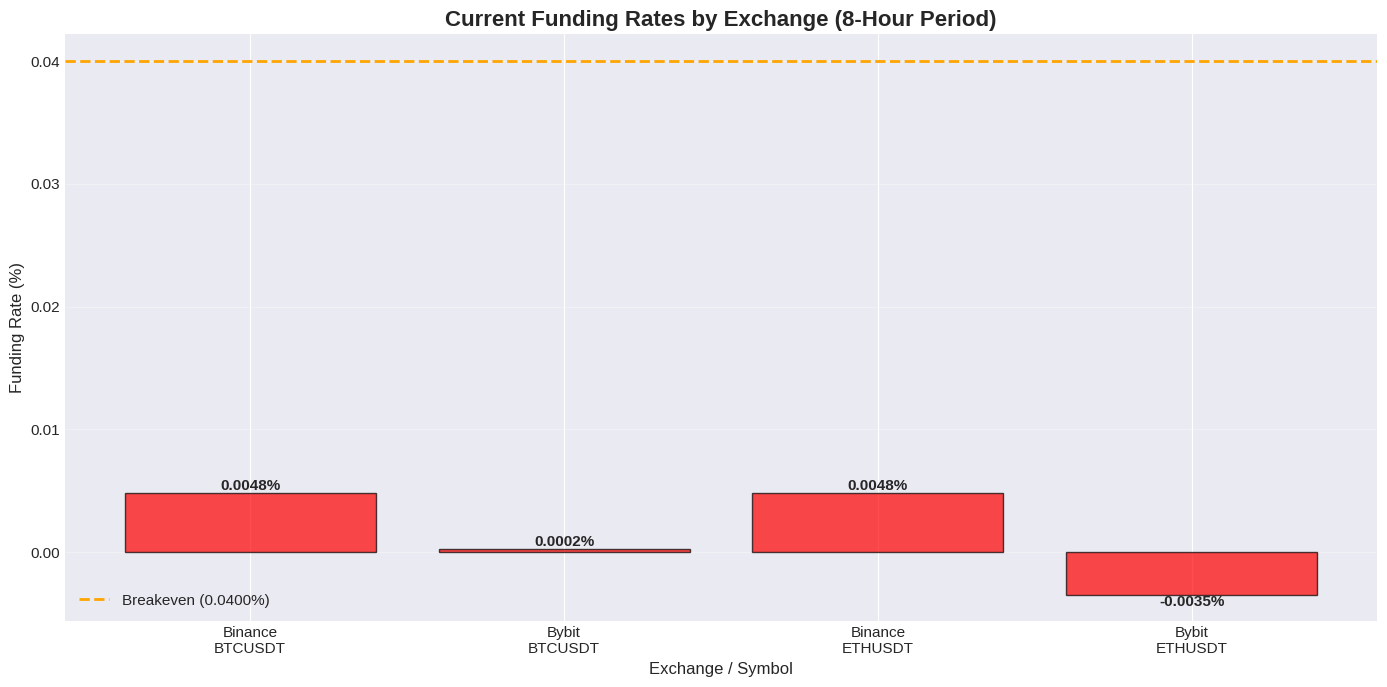

✅ Chart 1: Current funding rates comparison


In [5]:
fig, ax = plt.subplots(figsize=(14, 7))

# Create labels
df_current['label'] = df_current['exchange'] + '\n' + df_current['symbol']

# Color by profitability
colors = ['green' if x else 'red' for x in df_current['is_profitable']]

# Plot bars
bars = ax.bar(df_current['label'], df_current['funding_rate'], color=colors, alpha=0.7, edgecolor='black')

# Add breakeven line
ax.axhline(y=BREAKEVEN_PER_FUNDING, color='orange', linestyle='--', linewidth=2, label=f'Breakeven ({BREAKEVEN_PER_FUNDING:.4f}%)')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}%',
            ha='center', va='bottom' if height > 0 else 'top', fontsize=11, fontweight='bold')

ax.set_title('Current Funding Rates by Exchange (8-Hour Period)', fontsize=16, fontweight='bold')
ax.set_xlabel('Exchange / Symbol', fontsize=12)
ax.set_ylabel('Funding Rate (%)', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("✅ Chart 1: Current funding rates comparison")

### Chart 2: Historical Funding Rate Time Series (30 Days)

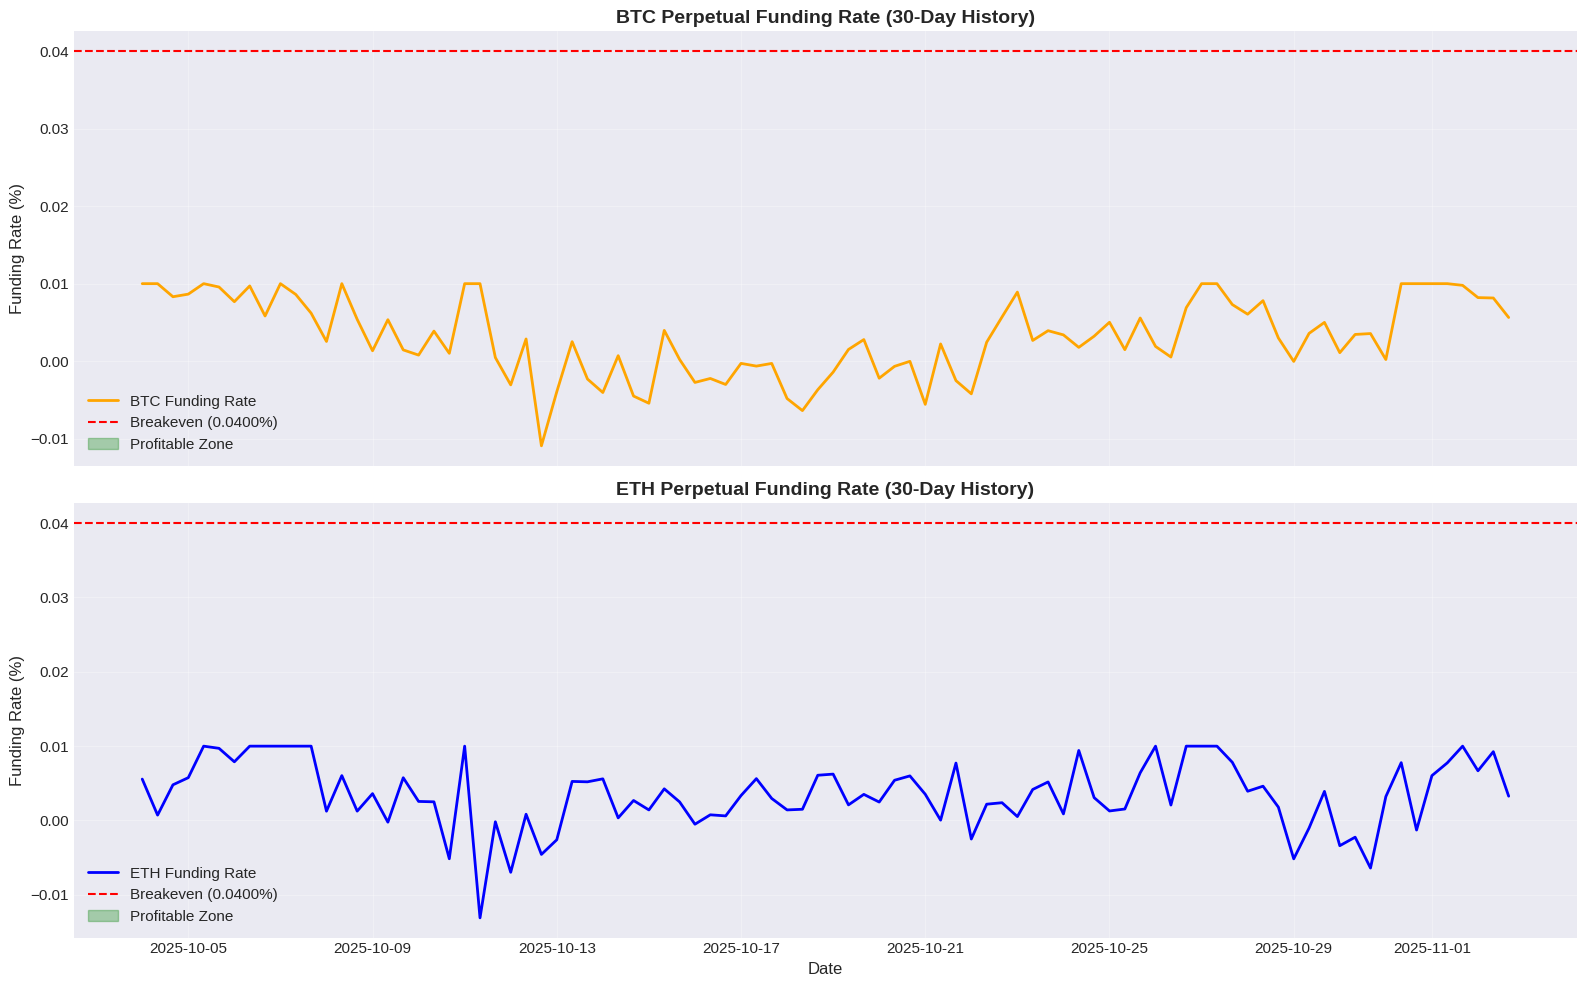

✅ Chart 2: Historical funding rate time series


In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# BTC funding rate
df_btc = df_history[df_history['symbol'] == 'BTCUSDT']
ax1.plot(df_btc['timestamp'], df_btc['funding_rate'], color='orange', linewidth=2, label='BTC Funding Rate')
ax1.axhline(y=BREAKEVEN_PER_FUNDING, color='red', linestyle='--', linewidth=1.5, label=f'Breakeven ({BREAKEVEN_PER_FUNDING:.4f}%)')
ax1.fill_between(df_btc['timestamp'], BREAKEVEN_PER_FUNDING, df_btc['funding_rate'], 
                 where=(df_btc['funding_rate'] > BREAKEVEN_PER_FUNDING), 
                 color='green', alpha=0.3, label='Profitable Zone')
ax1.set_title('BTC Perpetual Funding Rate (30-Day History)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Funding Rate (%)', fontsize=12)
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# ETH funding rate
df_eth = df_history[df_history['symbol'] == 'ETHUSDT']
ax2.plot(df_eth['timestamp'], df_eth['funding_rate'], color='blue', linewidth=2, label='ETH Funding Rate')
ax2.axhline(y=BREAKEVEN_PER_FUNDING, color='red', linestyle='--', linewidth=1.5, label=f'Breakeven ({BREAKEVEN_PER_FUNDING:.4f}%)')
ax2.fill_between(df_eth['timestamp'], BREAKEVEN_PER_FUNDING, df_eth['funding_rate'], 
                 where=(df_eth['funding_rate'] > BREAKEVEN_PER_FUNDING), 
                 color='green', alpha=0.3, label='Profitable Zone')
ax2.set_title('ETH Perpetual Funding Rate (30-Day History)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Funding Rate (%)', fontsize=12)
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Chart 2: Historical funding rate time series")

### Chart 3: Funding Rate Distribution (Histogram)

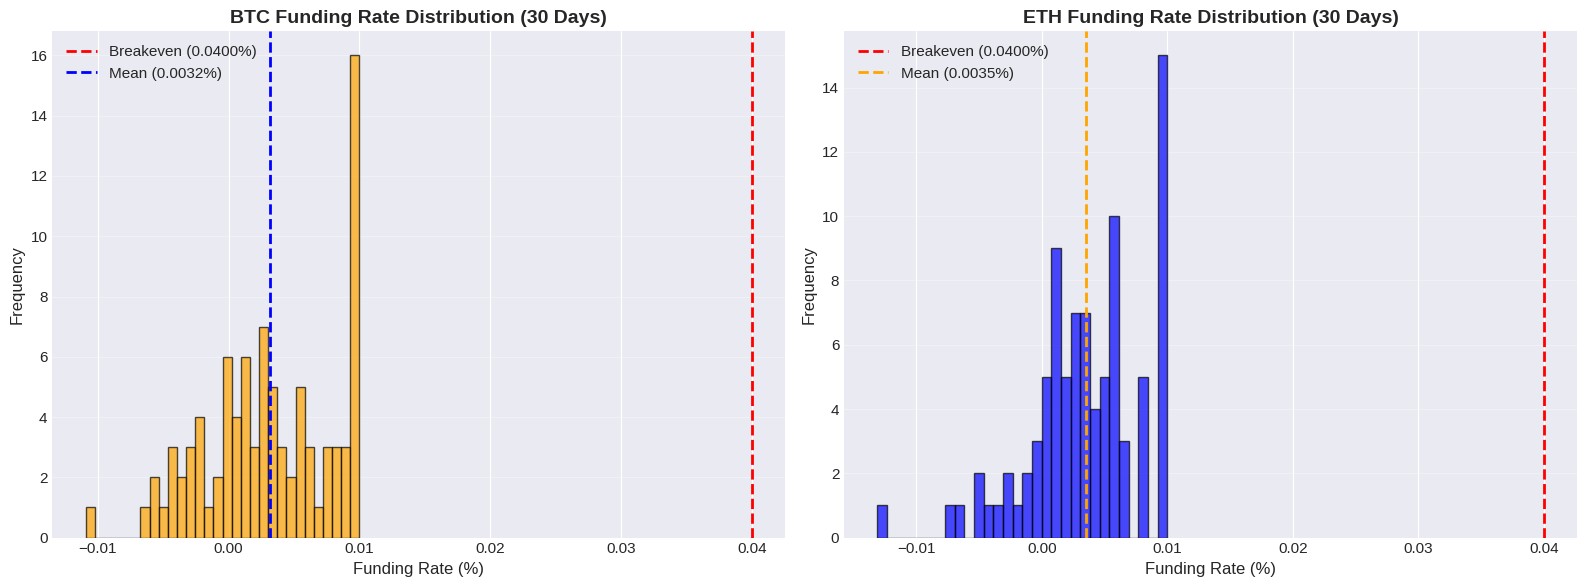

✅ Chart 3: Funding rate distribution


In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# BTC distribution
df_btc = df_history[df_history['symbol'] == 'BTCUSDT']
ax1.hist(df_btc['funding_rate'], bins=30, color='orange', alpha=0.7, edgecolor='black')
ax1.axvline(x=BREAKEVEN_PER_FUNDING, color='red', linestyle='--', linewidth=2, label=f'Breakeven ({BREAKEVEN_PER_FUNDING:.4f}%)')
ax1.axvline(x=df_btc['funding_rate'].mean(), color='blue', linestyle='--', linewidth=2, label=f'Mean ({df_btc["funding_rate"].mean():.4f}%)')
ax1.set_title('BTC Funding Rate Distribution (30 Days)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Funding Rate (%)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# ETH distribution
df_eth = df_history[df_history['symbol'] == 'ETHUSDT']
ax2.hist(df_eth['funding_rate'], bins=30, color='blue', alpha=0.7, edgecolor='black')
ax2.axvline(x=BREAKEVEN_PER_FUNDING, color='red', linestyle='--', linewidth=2, label=f'Breakeven ({BREAKEVEN_PER_FUNDING:.4f}%)')
ax2.axvline(x=df_eth['funding_rate'].mean(), color='orange', linestyle='--', linewidth=2, label=f'Mean ({df_eth["funding_rate"].mean():.4f}%)')
ax2.set_title('ETH Funding Rate Distribution (30 Days)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Funding Rate (%)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("✅ Chart 3: Funding rate distribution")

### Chart 4: Spot vs Futures Price Spread (Basis)

⚠️  Simulating spot-futures spread for educational purposes...



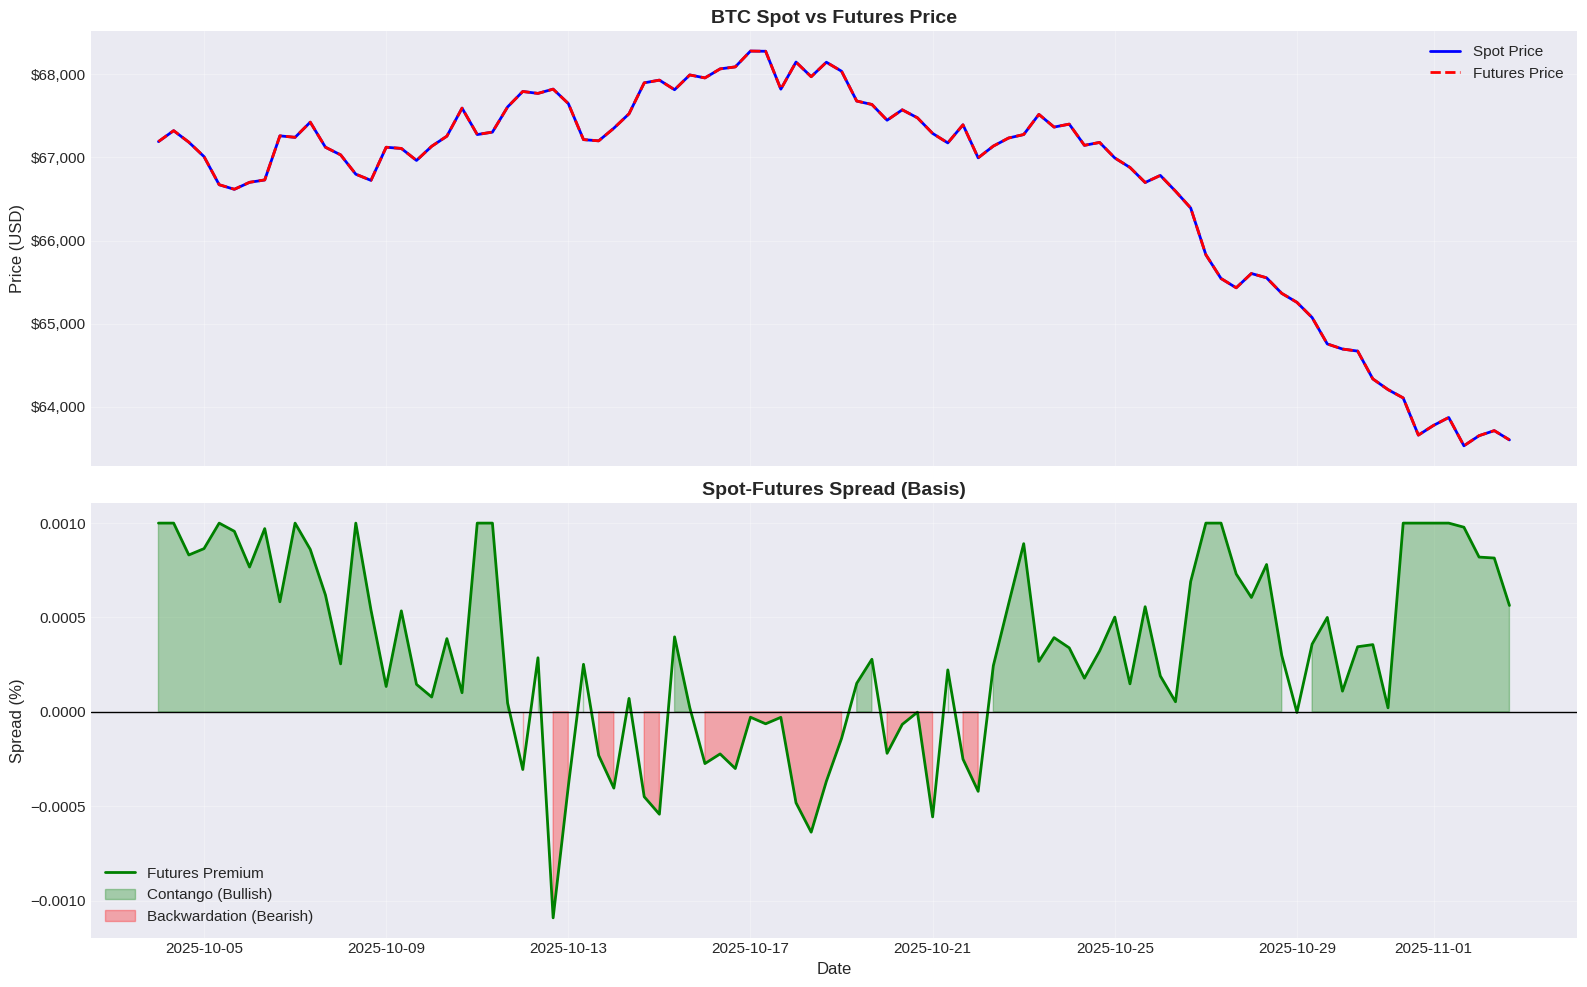

✅ Chart 4: Spot vs futures spread analysis

💡 Key Concepts:
   • Contango: Futures > Spot (positive funding, bullish sentiment)
   • Backwardation: Futures < Spot (negative funding, bearish sentiment)
   • Cash-and-carry works best in persistent contango


In [8]:
# Simulate spot vs futures spread
# In reality, you'd fetch both spot and futures prices
# For educational purposes, we'll generate realistic spread data

print("⚠️  Simulating spot-futures spread for educational purposes...\n")

# Use BTC history timestamps
df_btc = df_history[df_history['symbol'] == 'BTCUSDT'].copy()

# Simulate spot price (base)
base_price = 67000
df_btc['spot_price'] = base_price + np.cumsum(np.random.normal(0, 200, len(df_btc)))

# Futures price = spot + basis
# Basis correlates with funding rate (positive funding = futures premium)
df_btc['basis_bps'] = df_btc['funding_rate'] * 10  # Rough correlation
df_btc['futures_price'] = df_btc['spot_price'] * (1 + df_btc['basis_bps'] / 10000)
df_btc['spread_pct'] = (df_btc['futures_price'] - df_btc['spot_price']) / df_btc['spot_price'] * 100

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Prices
ax1.plot(df_btc['timestamp'], df_btc['spot_price'], label='Spot Price', color='blue', linewidth=2)
ax1.plot(df_btc['timestamp'], df_btc['futures_price'], label='Futures Price', color='red', linewidth=2, linestyle='--')
ax1.set_title('BTC Spot vs Futures Price', fontsize=14, fontweight='bold')
ax1.set_ylabel('Price (USD)', fontsize=12)
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Spread
ax2.plot(df_btc['timestamp'], df_btc['spread_pct'], color='green', linewidth=2, label='Futures Premium')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax2.fill_between(df_btc['timestamp'], 0, df_btc['spread_pct'], 
                 where=(df_btc['spread_pct'] > 0), color='green', alpha=0.3, label='Contango (Bullish)')
ax2.fill_between(df_btc['timestamp'], 0, df_btc['spread_pct'], 
                 where=(df_btc['spread_pct'] < 0), color='red', alpha=0.3, label='Backwardation (Bearish)')
ax2.set_title('Spot-Futures Spread (Basis)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Spread (%)', fontsize=12)
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Chart 4: Spot vs futures spread analysis")
print("\n💡 Key Concepts:")
print("   • Contango: Futures > Spot (positive funding, bullish sentiment)")
print("   • Backwardation: Futures < Spot (negative funding, bearish sentiment)")
print("   • Cash-and-carry works best in persistent contango")

### Chart 5: Arbitrage P&L Simulation

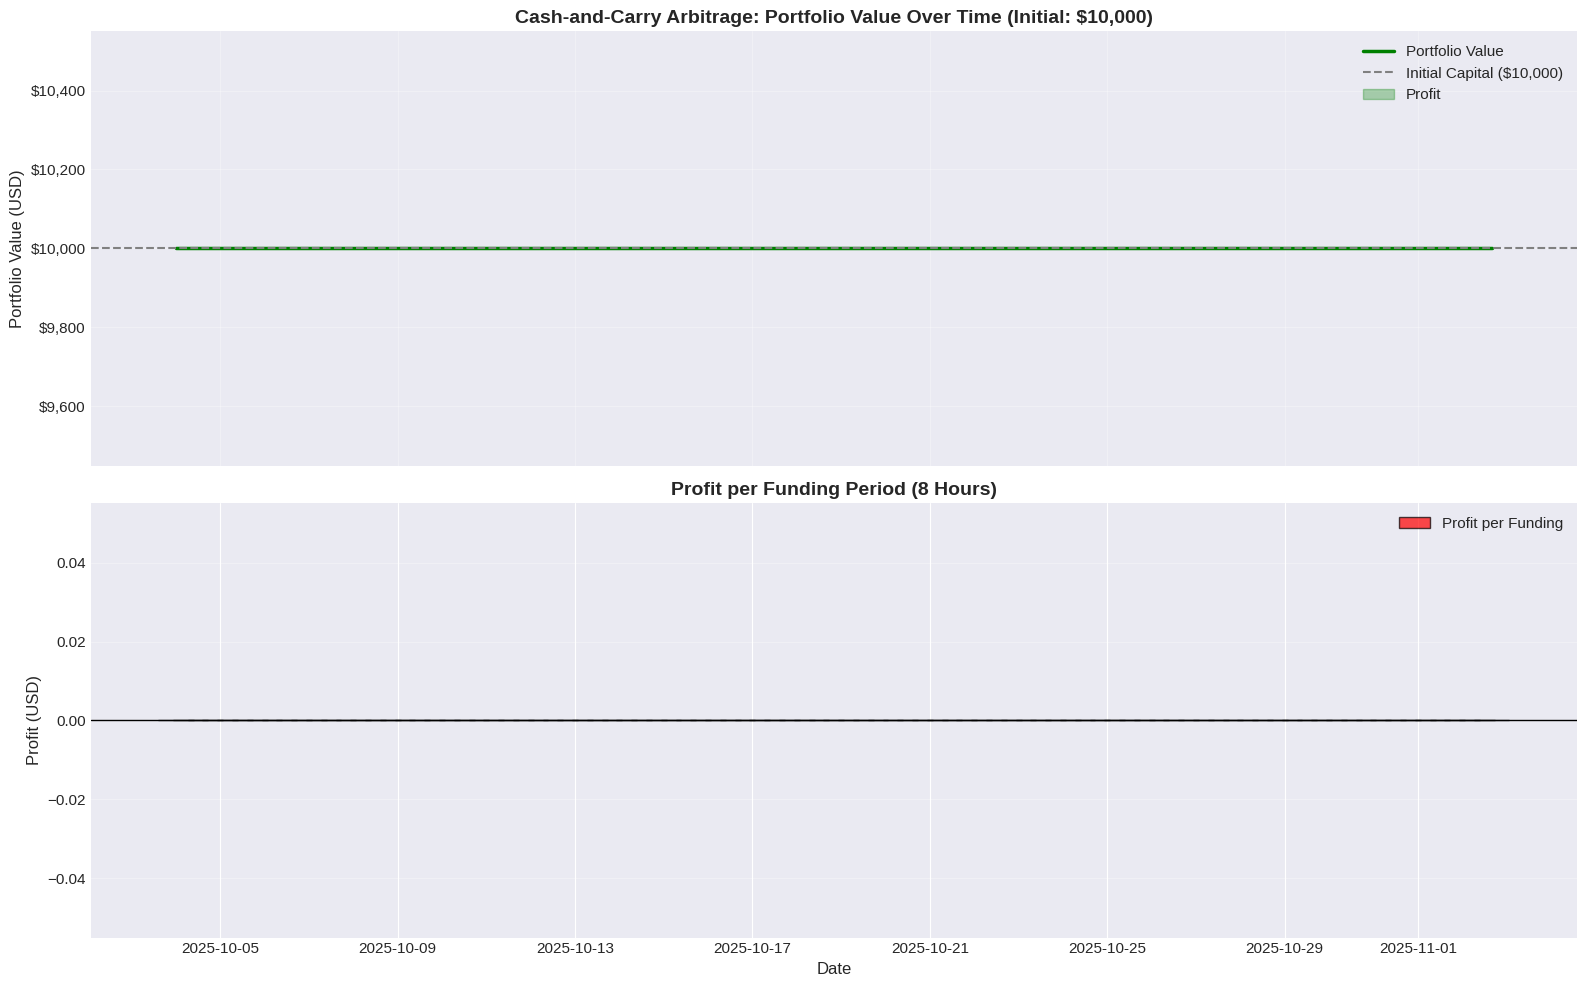


📊 ARBITRAGE SIMULATION RESULTS (30 Days)
   Initial Capital: $10,000
   Final Value: $10,000.00
   Total Profit: $0.00
   Return (30 days): +0.00%
   Annualized Return: +0.0%
✅ Chart 5: Arbitrage P&L simulation


In [9]:
# Simulate arbitrage P&L over 30 days
df_btc = df_history[df_history['symbol'] == 'BTCUSDT'].copy()

# Starting capital
initial_capital = 10000

# Calculate profits per funding period
df_btc['profit_per_period'] = df_btc.apply(
    lambda row: initial_capital * (row['funding_rate'] - BREAKEVEN_PER_FUNDING) / 100 
    if row['funding_rate'] > BREAKEVEN_PER_FUNDING else 0,
    axis=1
)

# Cumulative profit
df_btc['cumulative_profit'] = df_btc['profit_per_period'].cumsum()
df_btc['portfolio_value'] = initial_capital + df_btc['cumulative_profit']

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Portfolio value
ax1.plot(df_btc['timestamp'], df_btc['portfolio_value'], color='green', linewidth=2.5, label='Portfolio Value')
ax1.axhline(y=initial_capital, color='gray', linestyle='--', linewidth=1.5, label=f'Initial Capital (${initial_capital:,})')
ax1.fill_between(df_btc['timestamp'], initial_capital, df_btc['portfolio_value'], 
                 where=(df_btc['portfolio_value'] > initial_capital), 
                 color='green', alpha=0.3, label='Profit')
ax1.set_title(f'Cash-and-Carry Arbitrage: Portfolio Value Over Time (Initial: ${initial_capital:,})', fontsize=14, fontweight='bold')
ax1.set_ylabel('Portfolio Value (USD)', fontsize=12)
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Profit per funding period
ax2.bar(df_btc['timestamp'], df_btc['profit_per_period'], 
        color=['green' if x > 0 else 'red' for x in df_btc['profit_per_period']], 
        alpha=0.7, edgecolor='black', label='Profit per Funding')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax2.set_title('Profit per Funding Period (8 Hours)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Profit (USD)', fontsize=12)
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Calculate final results
final_value = df_btc['portfolio_value'].iloc[-1]
total_profit = df_btc['cumulative_profit'].iloc[-1]
total_return = (final_value / initial_capital - 1) * 100
annualized_return = total_return * (365 / 30)

print("\n" + "="*70)
print("📊 ARBITRAGE SIMULATION RESULTS (30 Days)")
print("="*70)
print(f"   Initial Capital: ${initial_capital:,}")
print(f"   Final Value: ${final_value:,.2f}")
print(f"   Total Profit: ${total_profit:,.2f}")
print(f"   Return (30 days): {total_return:+.2f}%")
print(f"   Annualized Return: {annualized_return:+.1f}%")
print("="*70)

print("✅ Chart 5: Arbitrage P&L simulation")

## 7. Key Findings and Risk Considerations

In [10]:
print("\n" + "="*70)
print("🎯 KEY FINDINGS: FUNDING RATE ARBITRAGE")
print("="*70)

print("\n💰 CASH-AND-CARRY ARBITRAGE MECHANICS:")
print("   1. Buy spot crypto (e.g., 1 BTC)")
print("   2. Short equal amount on perpetual futures")
print("   3. Position is delta-neutral (no price risk)")
print("   4. Collect funding rate every 8 hours (if positive)")
print("   5. Close when funding rate drops below breakeven")

print("\n📊 PROFITABILITY REQUIREMENTS:")
print(f"   • Breakeven funding rate: {BREAKEVEN_PER_FUNDING:.4f}% per 8H")
print(f"   • Breakeven annualized: {BREAKEVEN_ANNUAL:.1f}%")
print(f"   • Above this = profitable arbitrage")

print("\n⚠️  RISKS TO CONSIDER:")
print("   1. Funding rate risk: Rate can turn negative (you pay shorts)")
print("   2. Liquidation risk: Need sufficient margin for futures position")
print("   3. Exchange risk: Counterparty risk, exchange downtime")
print("   4. Execution risk: Slippage when entering/exiting positions")
print("   5. Opportunity cost: Capital locked, can't participate in spot rallies")

print("\n💡 WHEN DOES IT WORK BEST?")
print("   ✅ Persistent high funding rates (>0.05% per 8H)")
print("   ✅ Bullish market sentiment (contango)")
print("   ✅ Low volatility (reduces liquidation risk)")
print("   ✅ High liquidity (easy entry/exit)")

print("\n❌ WHEN TO AVOID:")
print("   ❌ Negative or near-zero funding rates")
print("   ❌ High volatility (liquidation risk)")
print("   ❌ Market uncertainty (funding can flip quickly)")
print("   ❌ Low liquidity (execution issues)")

print("\n🎓 LESSONS LEARNED:")
print("   • Funding rate arbitrage is NOT risk-free")
print("   • Requires active monitoring (rates change every 8H)")
print("   • Best as part of diversified strategy, not standalone")
print("   • Always account for all costs (fees, slippage, margin)")
print("   • Consider exchange risk and counterparty risk")

print("\n" + "="*70)
print("✅ Analysis complete! Notebook 3c finished.")
print("="*70)


🎯 KEY FINDINGS: FUNDING RATE ARBITRAGE

💰 CASH-AND-CARRY ARBITRAGE MECHANICS:
   1. Buy spot crypto (e.g., 1 BTC)
   2. Short equal amount on perpetual futures
   3. Position is delta-neutral (no price risk)
   4. Collect funding rate every 8 hours (if positive)
   5. Close when funding rate drops below breakeven

📊 PROFITABILITY REQUIREMENTS:
   • Breakeven funding rate: 0.0400% per 8H
   • Breakeven annualized: 43.8%
   • Above this = profitable arbitrage

⚠️  RISKS TO CONSIDER:
   1. Funding rate risk: Rate can turn negative (you pay shorts)
   2. Liquidation risk: Need sufficient margin for futures position
   3. Exchange risk: Counterparty risk, exchange downtime
   4. Execution risk: Slippage when entering/exiting positions
   5. Opportunity cost: Capital locked, can't participate in spot rallies

💡 WHEN DOES IT WORK BEST?
   ✅ Persistent high funding rates (>0.05% per 8H)
   ✅ Bullish market sentiment (contango)
   ✅ Low volatility (reduces liquidation risk)
   ✅ High liquidity

---

## Summary

This notebook analyzed **perpetual futures funding rates** and identified **cash-and-carry arbitrage opportunities**, as required by planning.pdf.

**What we learned:**
1. How to fetch and monitor funding rates across exchanges (Binance, Bybit)
2. How to calculate annualized funding rates
3. How to identify profitable arbitrage opportunities
4. How to set up a cash-and-carry arbitrage trade
5. How to calculate breakeven rates and profit margins
6. Key risks associated with funding rate arbitrage

**Key Takeaway:** Funding rate arbitrage can be profitable in bullish markets with persistent positive funding, but requires active monitoring and risk management.

**Next Steps:**
- Notebook 3d: RWA Tokenization Analysis

---